# Test of class Hamiltonian_QED

In [1]:
import qiskit

In [2]:
qiskit.__version__

'0.24.1'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from itertools import permutations,product

In [5]:
from Hamiltonian_QED import HamiltonianQED
from HC_Lattice import HCLattice
import primme

/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_55374/3502893271.py:3: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


In [6]:
#Qiskit import
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import qiskit.quantum_info as qinf
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
from sys import stdout
from qiskit.algorithms.optimizers import NFT,SLSQP,COBYLA,ADAM,SPSA
from qiskit.quantum_info.states import DensityMatrix
import qiskit.quantum_info as qinf
from qiskit.quantum_info import entropy


##### Quantum circuit

In [7]:
def gray_code_lim(l,theta=None,layers=1):
    """Return Gray code circuit for gauge field and truncation l=1,2,3,6,7,15."""
    if l not in [1,2,3,6,7,15]:
        raise ValueError('l must be 1,2,3,6,7,15')
    n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
    qc = QuantumCircuit(n_qubits)
    params = lambda i: Parameter(f'theta_{i}')

    if theta is None:
        t=0
    else:
        t=theta

    #First layer of ry gates
    for j in range(layers):
        for i in range(n_qubits-1):
            qc.ry(params(t),i)
            t+=1
        
    if l==2:
        for j in range(layers):
            qc.x(0)
            qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
            qc.x(0)
            t+=1

    else:
        #1st cry gate 
        for j in range(layers):
            qc.cry(params(t),n_qubits-2,n_qubits-1)
            t+=1

        if l==6:
            for j in range(layers):
                qc.x(0)
                qc.x(2)
                qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
                qc.x(0)
                qc.x(2)
                t+=1

        #2nd cry gate
        if l>1 and l!=6:
            for j in range(layers):
                qc.cry(params(t),n_qubits-3,n_qubits-1)
                t+=1

            # if l==14:#TODO see why qiskit error 
            #     qc.x(0)
            #     qc.x(2)
            #     qc.x(3)
            #     #qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
            #     qc.x(0)
            #     qc.x(2)
            #     qc.x(3)
            #     t+=1

            #layers of cry gates if l>3
            if l>3 and l!=14:
                for j in range(layers):
                    for i in range(1,n_qubits-2)[::-1]:
                        qc.cry(params(t),i-1,i)
                        t+=1

    par_list = [params(i) for i in range(t)]

    return qc,par_list

##### Quantum ansatz test

In [6]:
for l in range(1,16):
    print('unphys stases for l=',l,':',2**int(np.ceil(np.log2(2 * l+ 1)))-(2 * l + 1))

unphys stases for l= 1 : 1
unphys stases for l= 2 : 3
unphys stases for l= 3 : 1
unphys stases for l= 4 : 7
unphys stases for l= 5 : 5
unphys stases for l= 6 : 3
unphys stases for l= 7 : 1
unphys stases for l= 8 : 15
unphys stases for l= 9 : 13
unphys stases for l= 10 : 11
unphys stases for l= 11 : 9
unphys stases for l= 12 : 7
unphys stases for l= 13 : 5
unphys stases for l= 14 : 3
unphys stases for l= 15 : 1


In [7]:
l=3
print('unphys stases for l=',l,':',2**int(np.ceil(np.log2(2 * l+ 1)))-(2 * l + 1))
for i in range(0, 2 * l + 1):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

unphys stases for l= 3 : 1
000
001
011
010
110
111
101


In [8]:
#unphys states
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

100


In [9]:

for i in range(0, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

000
001
011
010
110
111
101
100


In [11]:
l=1

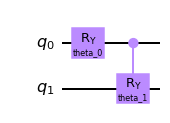

In [12]:
qc_test,par_list = gray_code_lim(l)

qc_test.draw('mpl')#,filename='gray_code_lim_l1.png')

In [13]:
theta_values_0 = np.linspace(0, np.pi, 4)  # Parameter values
#theta_values_0 = [0,np.pi/2,np.pi,3*np.pi/2,2*np.pi]


states_reached = []
for theta in list(product(theta_values_0, repeat=len(par_list))):
    bound_qc =qc_test.bind_parameters(dict(zip(qc_test.parameters,theta)))
    result = Statevector(bound_qc).probabilities_dict()


    for k in [key for key, value in result.items() if value >1e-16]:#consider nonzero probabilities
        if k not in states_reached:
            states_reached.append(k)
            

gray_unph = []
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    gray_unph.append("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))  

gray_phys = []
for i in range(0, 2 * l + 1):
    gray_decimal = i ^ (i >> 1)
    gray_phys.append("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

print('states reached:',states_reached,'states unphys:',gray_unph,'states phys:',gray_phys)
if set(states_reached)==set(gray_phys):
    print('all physical states reached : OK!')
else:
    print('not all physical states reached')

states reached: ['00', '01', '11'] states unphys: ['10'] states phys: ['00', '01', '11']
all physical states reached : OK!


##### Hamiltonian

In [100]:
#class input parameters:
n_sites = [2,4,]#how many sites for every dimension
g=0.5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=2
rotors = False
lambd = 1000
encoding = 'gray' ##'ed'#
magnetic_basis=False
pbc=False
puregauge = True 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 
sparse_pauli =False #false for circuit ansatz
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 3

In [101]:
latt = HCLattice(n_sites,pbc=pbc)

In [102]:
class_H = HamiltonianQED(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian,
                        sparse_pauli=sparse_pauli)

HamiltonianQED: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
> Pauli strings built
>> Gauss law applied and Hamiltonian built.  Execution time: 2.1128990650177 seconds
>> Suppression term built.  Execution time: 0.001798868179321289 seconds


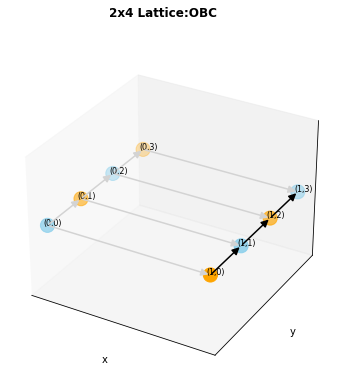

In [103]:

#latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H.e_op_free)#,savefig_dir='.')

In [104]:
class_H.uop_list

[U_11y, U_10y, U_12y]

##### Test composite circuit

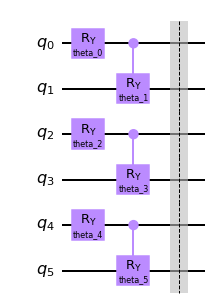

In [188]:
#ansatz
nlayers = 1#TODO ATTENTION: selection of only physical states work only for nlayers=1
ngauge = class_H.len_e_op
nsites = 0#TODO add fermionic part
n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
qc_tot = QuantumCircuit(n_qubits*ngauge+nsites)


th=0
#first gauge field
qcc,lst = gray_code_lim(l,theta=th,layers=nlayers)
qc_tot.compose(qcc,list(range(n_qubits)),inplace=True)

for i in range(1,ngauge):#for the other gauge fields
    theta = int(''.join(list(filter(str.isdigit, str(lst[-1])))))
    qcc,lst = gray_code_lim(l,theta=theta+1,layers=nlayers)
    qc_tot.compose(qcc,list(range(n_qubits*i,n_qubits*(i+1))),inplace=True)

th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))+1
qc_tot.barrier()

#**entanglement**
#between the gauge fields
# for i in range(n_qubits):
#     for j in range(n_qubits,n_qubits*ngauge):
#         qc_tot.cx(i,j)

#linear entanglement cx gates
# for i in range(n_qubits*ngauge-1):
#     qc_tot.cx(i,i+1)


#full entanglement cx gates
# for i in range(n_qubits*ngauge):
#     for j in range(i+1,n_qubits*ngauge):
#         qc_tot.cx(i,j)

qc_tot.draw('mpl')#,filename='gray_code_lim_l1.png')

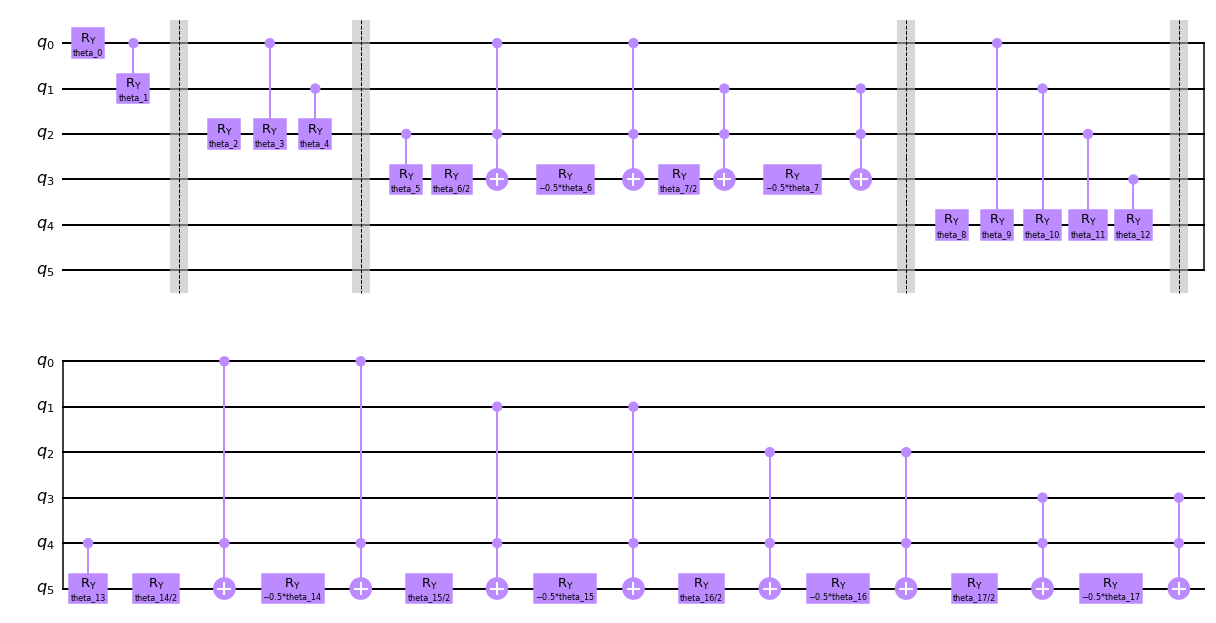

In [173]:
#ansatz
nlayers = 1#TODO ATTENTION: selection of only physical states work only for nlayers=1
ngauge = class_H.len_e_op
nsites = 0#TODO add fermionic part
n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
qc_tot2 = QuantumCircuit(n_qubits*ngauge+nsites)

th=0
#first gauge field
qcc,lst = gray_code_lim(l,theta=th,layers=nlayers)
qc_tot2.compose(qcc,list(range(n_qubits)),inplace=True)

qc_tot2.barrier()
th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))
qc_tot2.ry(Parameter(f'theta_{th+1}'),2)
qc_tot2.cry(Parameter(f'theta_{th+2}'),0,2)
qc_tot2.cry(Parameter(f'theta_{th+3}'),1,2)
qc_tot2.barrier()
qc_tot2.cry(Parameter(f'theta_{th+4}'),2,3)
qc_tot2.mcry(Parameter(f'theta_{th+5}'),[0,2],3)
qc_tot2.mcry(Parameter(f'theta_{th+6}'),[1,2],3)


qc_tot2.barrier()
qc_tot2.ry(Parameter(f'theta_{th+7}'),4)
qc_tot2.cry(Parameter(f'theta_{th+8}'),0,4)
qc_tot2.cry(Parameter(f'theta_{th+9}'),1,4)
qc_tot2.cry(Parameter(f'theta_{th+10}'),2,4)
qc_tot2.cry(Parameter(f'theta_{th+11}'),3,4)
qc_tot2.barrier()
qc_tot2.cry(Parameter(f'theta_{th+12}'),4,5)
qc_tot2.mcry(Parameter(f'theta_{th+13}'),[0,4],5)
qc_tot2.mcry(Parameter(f'theta_{th+14}'),[1,4],5)
qc_tot2.mcry(Parameter(f'theta_{th+15}'),[2,4],5)
qc_tot2.mcry(Parameter(f'theta_{th+16}'),[3,4],5)

qc_tot2.draw('mpl')#,filename='gray_code_lim_l1.png')

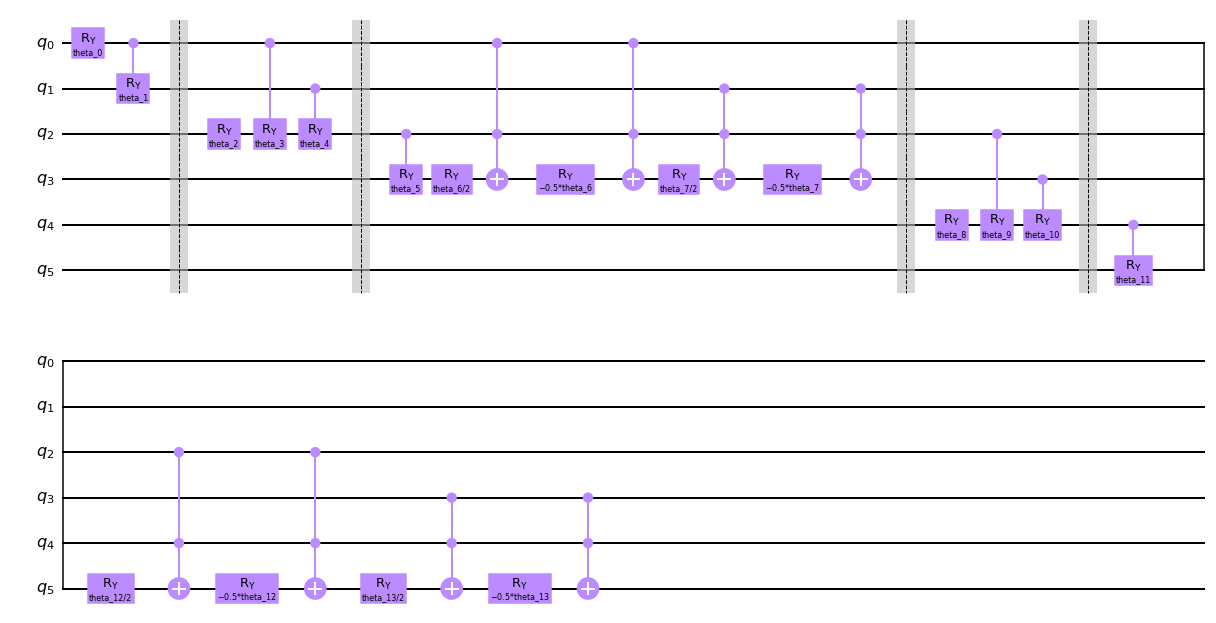

In [2227]:
#ansatz
nlayers = 1#TODO ATTENTION: selection of only physical states work only for nlayers=1
ngauge = class_H.len_e_op
nsites = 0#TODO add fermionic part
n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
qc_tot2 = QuantumCircuit(n_qubits*ngauge+nsites)

th=0
#first gauge field
qcc,lst = gray_code_lim(l,theta=th,layers=nlayers)
qc_tot2.compose(qcc,list(range(n_qubits)),inplace=True)

qc_tot2.barrier()
th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))
qc_tot2.ry(Parameter(f'theta_{th+1}'),2)
qc_tot2.cry(Parameter(f'theta_{th+2}'),0,2)
qc_tot2.cry(Parameter(f'theta_{th+3}'),1,2)
qc_tot2.barrier()
qc_tot2.cry(Parameter(f'theta_{th+4}'),2,3)
qc_tot2.mcry(Parameter(f'theta_{th+5}'),[0,2],3)
qc_tot2.mcry(Parameter(f'theta_{th+6}'),[1,2],3)


qc_tot2.barrier()
qc_tot2.ry(Parameter(f'theta_{th+7}'),4)
qc_tot2.cry(Parameter(f'theta_{th+8}'),2,4)
qc_tot2.cry(Parameter(f'theta_{th+9}'),3,4)
qc_tot2.barrier()
qc_tot2.cry(Parameter(f'theta_{th+10}'),4,5)
qc_tot2.mcry(Parameter(f'theta_{th+11}'),[2,4],5)
qc_tot2.mcry(Parameter(f'theta_{th+12}'),[3,4],5)

qc_tot2.draw('mpl')#,filename='gray_code_lim_l1.png')

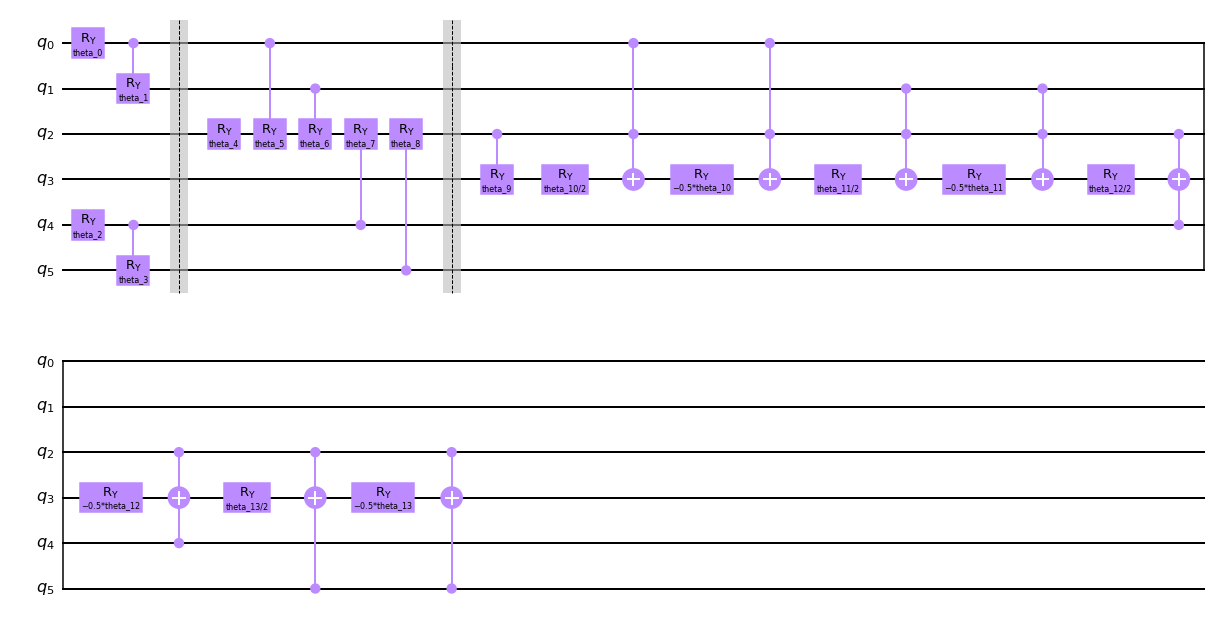

In [123]:
#ansatz
nlayers = 1#TODO ATTENTION: selection of only physical states work only for nlayers=1
ngauge = class_H.len_e_op
nsites = 0#TODO add fermionic part
n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
qc_tot2 = QuantumCircuit(n_qubits*ngauge+nsites)

th=0
#first gauge field
qcc,lst = gray_code_lim(l,theta=th,layers=nlayers)
qc_tot2.compose(qcc,list(range(n_qubits)),inplace=True)


th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))
qcc,lst = gray_code_lim(l,theta=th+1,layers=nlayers)
qc_tot2.compose(qcc,list(range(4,6)),inplace=True)

qc_tot2.barrier()
th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))
qc_tot2.ry(Parameter(f'theta_{th+1}'),2)
qc_tot2.cry(Parameter(f'theta_{th+2}'),0,2)
qc_tot2.cry(Parameter(f'theta_{th+3}'),1,2)
qc_tot2.cry(Parameter(f'theta_{th+4}'),4,2)
qc_tot2.cry(Parameter(f'theta_{th+5}'),5,2)
qc_tot2.barrier()

qc_tot2.cry(Parameter(f'theta_{th+6}'),2,3)
qc_tot2.mcry(Parameter(f'theta_{th+7}'),[0,2],3)
qc_tot2.mcry(Parameter(f'theta_{th+8}'),[1,2],3)
qc_tot2.mcry(Parameter(f'theta_{th+9}'),[4,2],3)
qc_tot2.mcry(Parameter(f'theta_{th+10}'),[5,2],3)


qc_tot2.draw('mpl')#,filename='gray_code_lim_l1.png')

In [124]:
def fidelity_func(myvqd_results2,eigenvectors_matrix,num_eigs):

    """ Inputs; results from VQD and eigenvector matrix from ED. Update to Qiskit version 0.24.1"""
    
    vqd_states = [myvqd_results2.optimal_circuits[i].bind_parameters(myvqd_results2.optimal_parameters[i].values()) for i in range(num_eigs)]

    vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
    ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]

    return [qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)]

In [195]:
#Input parameters for VQD
estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

iterations = [100 for i in range(num_eigs)]
optimizer = [SLSQP(maxiter=itr) for itr in iterations]
ansatz = qc_tot2
betas = [5,]*(num_eigs-1)#[4,0.5]#[5,]*(num_eigs-1)   #***default value computed as the mean square sum of the coefficients of the observable.
val_init = np.pi/4

initial_point=[val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) for kkk in range(num_eigs)]
#initial_point=val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) 


Hamiltonian_Pauli_tot_vqd = class_H.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0)

In [196]:
#ED
import scipy.sparse as sp
Hamiltonian_Pauli_tot = class_H.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
#print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
if encoding=='gray' and not sparse_pauli:
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
    h_b_sparse = class_H.hamiltonian_mag_pauli.to_matrix(sparse=True) #plaquette
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    h_b_sparse =sp.csr_matrix(class_H.hamiltonian_mag_pauli)

#** Exact diagonalisation
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort() 
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]
ed_val = []
for kk in range(num_eigs):
    ed_val.append(dict([(str(np.binary_repr(i, width = (ngauge*n_qubits))),np.abs(eigenvectors_matrix[:,kk][i])**2) for i in range(2**(ngauge*n_qubits)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-4]))

eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()
eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real

In [197]:
#****Entropy ED: between the gauge fields only (not internal qubits)
S_ed_list = []
for k in range(num_eigs):
    print(f'entropy E_{k}')
    s_tmp = []
    for i in range(ngauge-1):
        S_ed = entropy(qinf.partial_trace(DensityMatrix(eigenvectors_matrix[:,k]), list(range(0,(i+1)*n_qubits))))
        print('A=',list(range(0,(i+1)*n_qubits)),'B=',list(range((i+1)*n_qubits,ngauge*n_qubits)),'S=',S_ed)
        s_tmp.append(S_ed)
    S_ed_list.append(s_tmp)
print('circuits entropy')
#circuit, tried with some values of thetas
circ = qc_tot2
for i in range(ngauge-1):
    print('A=',list(range(0,(i+1)*n_qubits)),'B=',list(range((i+1)*n_qubits,ngauge*n_qubits)),'S=',
            [np.round(entropy(qinf.partial_trace(DensityMatrix(circ.bind_parameters([np.pi/p]*circ.num_parameters )), list(range(0,(i+1)*n_qubits)))),5) for p in [0.25,0.5,1,2,4]])

entropy E_0
A= [0, 1] B= [2, 3, 4, 5] S= 0.008173202563347214
A= [0, 1, 2, 3] B= [4, 5] S= 0.004433641255753721
entropy E_1
A= [0, 1] B= [2, 3, 4, 5] S= 0.9999906081084456
A= [0, 1, 2, 3] B= [4, 5] S= 0.8141210969371921
entropy E_2
A= [0, 1] B= [2, 3, 4, 5] S= 0.005999047682374474
A= [0, 1, 2, 3] B= [4, 5] S= 1.0029991064170776
circuits entropy
A= [0, 1] B= [2, 3, 4, 5] S= [0.0, 0.0, 0.0, 1.33407, 0.33733]
A= [0, 1, 2, 3] B= [4, 5] S= [0.0, 0.0, 0.0, 1.23229, 0.50577]


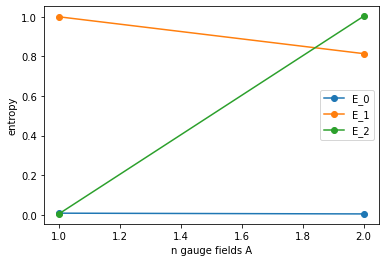

In [198]:
[plt.plot(range(1,ngauge),val,marker='o',label=f'E_{j}') for j,val in enumerate(S_ed_list) ]
plt.xlabel('n gauge fields A')
plt.ylabel('entropy')
plt.legend()

In [199]:
from qiskit.algorithms.eigensolvers import VQD

#callback function
E_data = [[] for k in range(num_eigs)]
Fidelity = [[] for k in range(num_eigs)]
def callback(eval_count, parameters, mean, meta, step):
    stdout.write("eig: %d/%d -> its %4d/%d \r"%(step,num_eigs,eval_count,2*iterations[step-1]+51)) # assuming SPSA
    stdout.flush()

    #fidelity
    vqd_states = [ansatz.bind_parameters(parameters) for i in range(num_eigs)]
    vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
    ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]
    Fidelity[step-1].append([qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)])

    #energy
    E_data[step-1].append([len(E_data[step-1]),mean,meta])

#Perform VQD for Hamiltonian and plaquette operator
vqd = VQD(estimator, fidelity, ansatz, optimizer, k=num_eigs, betas=betas,initial_point=initial_point,  callback=callback)
result = vqd.compute_eigenvalues(operator = Hamiltonian_Pauli_tot_vqd,aux_operators = [class_H.hamiltonian_mag_pauli,])# Hamiltonian + auxiliary operator
vqd_values = result.eigenvalues

#eigenvectors
vqd2_eigenstates = []
for i in range(num_eigs):
    tmp = result.optimal_circuits[i].copy()
    
    tmp.measure_all()
    opt_pt =list(result.optimal_parameters[i].values())
    res = sampler.run(tmp, opt_pt).result() 
    
    vqd2_eigenstates.append({x:round(y,6) for x,y in res.quasi_dists[0].binary_probabilities().items() if y>0.0001})
    tmp.remove_final_measurements()

plaq_vqd = np.array(result.aux_operators_evaluated[0])[:,0][0]/len(latt.plaq_list)

In [200]:


print(f'E_i ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega} nlayers{nlayers} iterations{iterations} optimizer'+
[i for i in ['NFT','SLSQP','COBYLA','ADAM','SPSA'] if i in str(optimizer[0])][0])

#** Print results
for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
            print(f'E_{kk}(ED)=',round(evalu,8))#,[(str(np.binary_repr(i, width = (ngauge*n_qubits))),round(np.abs(eigenvectors_matrix[:,kk][i])**2,6)) for i in range(2**(ngauge*n_qubits)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-4])
            print(f'E_{kk}(VQD)=',vqd_values.real[kk])#,vqd2_eigenstates[kk])

#** Plaquette operator
print('\n','Plaq. ED:',plaq,'Plaq. VQD:',plaq_vqd.real,'\n')
#** Fidelity final
fid=fidelity_func(result,eigenvectors_matrix,num_eigs)
                   

print('Fidelity (|psi_VQDXpsi_ED|^2):')
[print(f'E_{i}:',fd) for i,fd in enumerate(fid)]


#**Check if there are unphysical states
gray_unph = []
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    gray_unph.append("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))  
print('Check if in VQD sol. there are unphysical states:',gray_unph)
for i in range(num_eigs):
    for vqd_res in [string[i:i+int(np.ceil(np.log2(2 * l+ 1)))] for string in vqd2_eigenstates[i].keys() for i in range(0, len(string), int(np.ceil(np.log2(2 * l+ 1))))]:
        if vqd_res in gray_unph:
            print('unphysical state reached')
            break
    else:   
        print(f'E_{i} all physical states reached : OK!')


E_i ED vs VQD test:2D_2x4mbasisFalse puregaugeTrue g0.5 pbcFalse l1_factE1_factB1_m3_Omega1 nlayers1 iterations[100, 100, 100] optimizerSLSQP
E_0(ED)= -7.77257715
E_0(VQD)= -7.772576615667781
E_1(ED)= -4.84638535
E_1(VQD)= -4.803328418086027
E_2(ED)= -4.68164043
E_2(VQD)= -4.573845639920105

 Plaq. ED: 0.7041063744787566 Plaq. VQD: 0.70410854895113 

Fidelity (|psi_VQDXpsi_ED|^2):
E_0: 0.9999999209202053
E_1: 0.7714037486387154
E_2: 0.28133754739064326
Check if in VQD sol. there are unphysical states: ['10']
E_0 all physical states reached : OK!
E_1 all physical states reached : OK!
E_2 all physical states reached : OK!


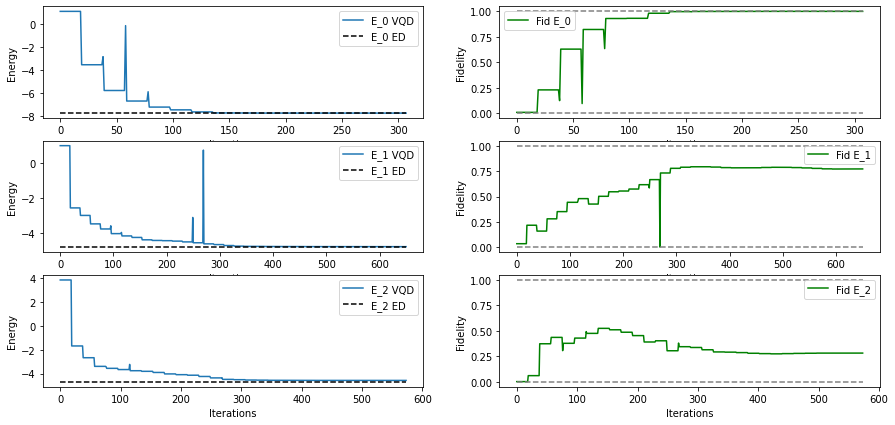

In [201]:
fig,axes = plt.subplots(num_eigs,2,figsize=(15,7))

for k in range(num_eigs):
    #Energy
    axes[k][0].plot([i[0] for i in E_data[k]],[i[1] for i in E_data[k]],label=f'E_{k} VQD')
    axes[k][0].hlines(spectrum[k],0,E_data[k][-1][0],linestyles='dashed',color='black',label=f'E_{k} ED')

    #Fidelity
    axes[k][1].plot([i[0] for i in E_data[k]],[i[k] for i in Fidelity[k]],label=f'Fid E_{k}',color='green')
    #fidelity max value 1 and min 0
    axes[k][1].hlines(1,0,E_data[k][-1][0],linestyles='dashed',color='gray')
    axes[k][1].hlines(0,0,E_data[k][-1][0],linestyles='dashed',color='gray')

    axes[k][0].set_ylabel('Energy')
    axes[k][1].set_ylabel('Fidelity')

    for i in range(2):
        axes[k][i].set_xlabel('Iterations')
        axes[k][i].legend()

#fig.savefig('ansatz_tests/'+f'Energy_Fidelity_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}.png')

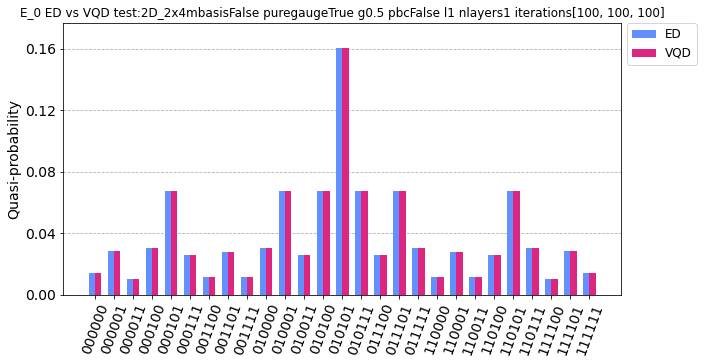

In [202]:
from qiskit.visualization import plot_histogram
plot_histogram([ed_val[0],vqd2_eigenstates[0]], figsize=(10,5),legend=['ED','VQD'] ,bar_labels=False,
               title=f'E_0 ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l} nlayers{nlayers} iterations{iterations}')
               #,filename='ansatz_tests/'+f'E_0_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}')


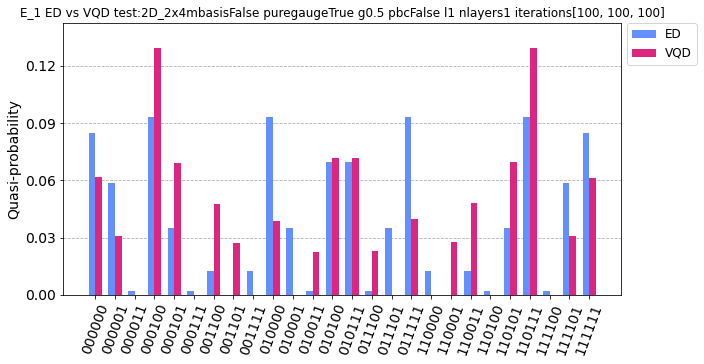

In [203]:
plot_histogram([ed_val[1],vqd2_eigenstates[1]], figsize=(10,5),legend=['ED','VQD'] ,bar_labels=False,
               title=f'E_1 ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l} nlayers{nlayers} iterations{iterations}')
               #,filename='ansatz_tests/'+f'E_1_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}')

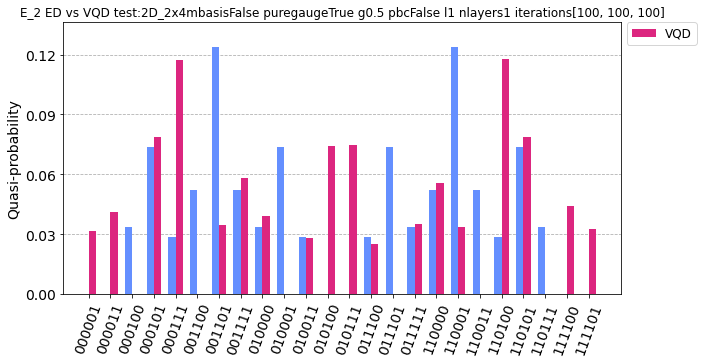

In [204]:
plot_histogram([ed_val[2],vqd2_eigenstates[2]], figsize=(10,5),legend=['ED','VQD'] ,bar_labels=False,
               title=f'E_2 ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l} nlayers{nlayers} iterations{iterations}')
               #,filename='ansatz_tests/'+f'E_1_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}')


With 2x2 obc (only single gauge field) system ok energies and e.states also for exicted states 
With 2x3 obc ok only ground state